### ***Install Dependencies***

In [ ]:
!pip install -q accelerate Evaluate
!pip list

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.5 MB/s eta 0:00:00
Package                                  Version
---------------------------------------- -------------------
absl-py                                  1.4.0
accelerate                               1.12.0
access                                   1.1.10.post3
affine                                   2.4.0
aiofiles                                 24.1.0
aiohappyeyeballs                         2.6.1
aiohttp                                  3.13.3
aiosignal                                1.4.0
aiosqlite                                0.22.1
alabaster                                1.0.0
albucore                                 0.0.24
albumentations                           2.0.8
ale-py                                   0.11.2
alembic                                  1.18.2
altair                                   5.5.0
annotated-doc                            0.0.4
annotated-types                          0.7.0

## ***Import dependencies***

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import os
import torch
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    balanced_accuracy_score,
    accuracy_score, f1_score, precision_score, recall_score,
    precision_recall_fscore_support,
    confusion_matrix, classification_report,
)
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    set_seed,
    AutoConfig
)
from datasets import Dataset
os.environ["WANDB_DISABLED"] = "true"

## ***Seed***

In [ ]:
# Fijar semilla global
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# ***TRAIN K-FOLD PIPELINE***

## ***Utils***

In [ ]:
def plot_confusion_matrix(y_true, y_pred, id2label, title="Matriz de Confusión"):
    """
    Función genérica para graficar matriz de confusión
    y_true: etiquetas reales
    y_pred: etiquetas predichas
    id2label: diccionario {id: clase}
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(
        cm,
        index=[id2label[i] for i in range(len(id2label))],
        columns=[id2label[i] for i in range(len(id2label))]
    )

    print("\nMatriz de Confusión (Frecuencias):")
    print(cm_df)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('Clase real')
    plt.xlabel('Predicción')
    plt.title(title)
    plt.show()

def plot_training_curves(trainer):
    """
    Grafica únicamente train loss vs validation loss
    en base a los logs de HuggingFace Trainer.
    """
    logs = pd.DataFrame(trainer.state.log_history)

    # Extraer valores de pérdida
    train_loss = logs[['epoch', 'loss']].dropna()
    val_loss   = logs[['epoch', 'eval_loss']].dropna()

    plt.figure(figsize=(8,6))
    plt.plot(train_loss['epoch'], train_loss['loss'], marker='o', label="Train Loss")
    plt.plot(val_loss['epoch'], val_loss['eval_loss'], marker='o', label="Validation Loss")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.title("Curva de entrenamiento (Loss)")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_kfold_final_confusion_matrix(conf_matrix_total, id2label):
    """
    Grafica matriz de confusión final (10-Fold)
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        conf_matrix_total,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=list(id2label.values()),
        yticklabels=list(id2label.values())
    )
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión Final (10-Fold)")
    plt.show()

## ***Pipeline: run kfold function***

In [ ]:
def run_kfold_experiment(df, model_name, max_length=512, lr=5e-5, batch_size=8, n_splits=10):
    """
    Engloba el entrenamiento con K-Fold Cross Validation parametrizado y logs de tiempo.
    """
    # ==================== 1. Preparación de etiquetas ==============================
    classes_to_keep = ['O', 'PE', 'SE', 'US', 'LF', 'A', 'FT', 'SC', 'L', 'MN']
    df = df[df['class'].isin(classes_to_keep)].copy()

    print("\n----- Class Distribution: -----\n")
    for cls, count in df['class'].value_counts().items():
        print(f"  {cls:<20} : {count:>6}")
    print("-" * 25)

    # Mapear clases a IDs
    label2id = {label: idx for idx, label in enumerate(df['class'].unique())}
    id2label = {idx: label for label, idx in label2id.items()}
    df['label'] = df['class'].map(label2id)

    X = df['RequirementText'].values
    y = df['label'].values

    # ==================== 2. Tokenizer ====================
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def tokenize_function(examples):
        return tokenizer(
            examples["RequirementText"],
            padding="max_length",
            truncation=True,
            max_length=max_length
        )

    # ==================== 3. Métricas de evaluación ====================
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return {
            "accuracy": accuracy_score(labels, predictions),
            "f1": f1_score(labels, predictions, average='weighted', zero_division=0),
            "precision": precision_score(labels, predictions, average='weighted', zero_division=0),
            "recall": recall_score(labels, predictions, average='weighted', zero_division=0),
        }

    # ==================== 4. K-Fold Setup y Acumuladores ====================
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

    all_metrics = {"acc": [], "f1_m": [], "prec_m": [], "rec_m": [], "f1_w": [], "prec_w": [], "rec_w": []}
    per_class_metrics = {cls: {"precision": [], "recall": [], "f1": []} for cls in label2id.keys()}
    conf_matrix_total = np.zeros((len(label2id), len(label2id)), dtype=int)

    # Listas para logs de tiempo
    total_start_time = time.time()
    fold_times = [] # tiempo/fold
    epochs_trained = [] # epocas/fold
    epoch_durations = [] # tiempo promedio por epoca/fold

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n==================== FOLD {fold+1}/{n_splits} ====================")
        fold_start_time = time.time()

        train_dataset = Dataset.from_pandas(df.iloc[train_idx])
        val_dataset = Dataset.from_pandas(df.iloc[val_idx])

        tokenized_train = train_dataset.map(tokenize_function, batched=True)
        tokenized_val = val_dataset.map(tokenize_function, batched=True)

        model = AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=len(label2id), id2label=id2label, label2id=label2id
        )

        # Congelar capas iniciales (fine-tunning)
        layers = model.base_model.encoder.layer
        for layer in layers[:6]: # Congela 6 de 12
            for param in layer.parameters():
                param.requires_grad = False

        training_args = TrainingArguments(
            output_dir=f"./results_10class_length{max_length}/fold_{fold+1}",
            eval_strategy="epoch",
            save_strategy="epoch",
            logging_strategy="epoch",
            learning_rate=lr,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=10,
            weight_decay=0.01,
            load_best_model_at_end=True,
            metric_for_best_model="f1",
            logging_dir=f"./logs/results_10class_length{max_length}/fold_{fold+1}",
            report_to="none", # tensorboard
            save_total_limit=1
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_train,
            eval_dataset=tokenized_val,
            compute_metrics=compute_metrics,
            # data_collator=data_collator
            # tokenizer=tokenizer,
            # callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
        )

        # Entrenamiento
        train_result = trainer.train()

        # --- [LOGS: Tiempos] ---
        fold_end_time = time.time()
        fold_duration = fold_end_time - fold_start_time
        actual_epochs = trainer.state.epoch
        train_runtime = train_result.metrics["train_runtime"]
        fold_times.append(fold_duration)
        epochs_trained.append(actual_epochs)
        epoch_durations.append(train_runtime / actual_epochs)

        # --- Procesamiento de Resultados ---
        preds = trainer.predict(tokenized_val)
        pred_labels = np.argmax(preds.predictions, axis=1)
        true_labels = df.iloc[val_idx]['label'].values

        all_metrics["acc"].append(accuracy_score(true_labels, pred_labels))
        all_metrics["f1_m"].append(f1_score(true_labels, pred_labels, average='macro', zero_division=0))
        all_metrics["prec_m"].append(precision_score(true_labels, pred_labels, average='macro', zero_division=0))
        all_metrics["rec_m"].append(recall_score(true_labels, pred_labels, average='macro', zero_division=0))
        all_metrics["f1_w"].append(f1_score(true_labels, pred_labels, average='weighted', zero_division=0))
        all_metrics["prec_w"].append(precision_score(true_labels, pred_labels, average='weighted', zero_division=0))
        all_metrics["rec_w"].append(recall_score(true_labels, pred_labels, average='weighted', zero_division=0))

        # Acumular Matriz de confusion
        conf_matrix_total += confusion_matrix(true_labels, pred_labels, labels=list(range(len(label2id))))

        # Métricas por clase de este fold
        precs, recs, f1s, _ = precision_recall_fscore_support(
            true_labels, pred_labels, labels=list(range(len(label2id))), zero_division=0
        )
        for i, cls in id2label.items():
            per_class_metrics[cls]["precision"].append(precs[i])
            per_class_metrics[cls]["recall"].append(recs[i])
            per_class_metrics[cls]["f1"].append(f1s[i])

    # ==================== 5. Resultados ====================
    total_end_time = time.time()
    total_duration_min = (total_end_time - total_start_time) / 60

    print("\n" + "="*40)
    print("REPORTE DE TIEMPOS DE EJECUCIÓN")
    print("="*40)
    print(f"Tiempo/época promedio (s)   : {np.mean(epoch_durations):.2f} s")
    print(f"Tiempo/fold promedio (min)  : {(np.mean(fold_times)/60):.2f} min")
    print(f"Tiempo Total (min)          : {total_duration_min:.2f} min")
    print(f"Nro Épocas/fold promedio    : {np.mean(epochs_trained):.1f} épocas")

    print("\n" + "="*40)
    print(f"RESULTADOS FINALES (MAX_LENGTH: {max_length}, BATCH_SIZE: {batch_size}, LR: {lr})")
    print("="*40)
    print(f"Accuracy promedio: {np.mean(all_metrics['acc']):.4f}")

    print(f"Precision Weighted promedio: {np.mean(all_metrics['prec_w']):.4f}")
    print(f"Recall Weighted promedio: {np.mean(all_metrics['rec_w']):.4f}")
    print(f"F1-Score Weighted promedio: {np.mean(all_metrics['f1_w']):.4f}")

    print(f"Precision Macro promedio: {np.mean(all_metrics['prec_m']):.4f}")
    print(f"Recall Macro promedio: {np.mean(all_metrics['rec_m']):.4f}")
    print(f"F1-Score Macro promedio: {np.mean(all_metrics['f1_m']):.4f}")

    print("\n===== Matriz de Confusión Acumulada =====")
    class_names = [id2label[i] for i in range(len(id2label))]
    cm_df = pd.DataFrame(
        conf_matrix_total,
        index=class_names,
        columns=class_names
    )
    cm_df.index.name = 'True\Pred' # Asignamos el indicador en la esquina
    # Forzamos a Pandas a mostrar todas las columnas sin saltos de línea
    with pd.option_context('display.max_columns', None, 'display.width', 1000):
        print(cm_df)

    print("\n--- Métricas por Clase (Promedio de 10 Pliegues) ---")
    for cls in per_class_metrics.keys():
        prec_mean, prec_std = np.mean(per_class_metrics[cls]["precision"]), np.std(per_class_metrics[cls]["precision"])
        rec_mean, rec_std   = np.mean(per_class_metrics[cls]["recall"]), np.std(per_class_metrics[cls]["recall"])
        f1_mean, f1_std     = np.mean(per_class_metrics[cls]["f1"]), np.std(per_class_metrics[cls]["f1"])

        print(f"Clase: {cls}")
        print(f"  - Precision: {prec_mean:.4f} (+/- {prec_std:.4f})")
        print(f"  - Recall:    {rec_mean:.4f} (+/- {rec_std:.4f})")
        print(f"  - F1-Score:  {f1_mean:.4f} (+/- {f1_std:.4f})")


<>:176: SyntaxWarning: invalid escape sequence '\P'
<>:176: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipython-input-1505083013.py:176: SyntaxWarning: invalid escape sequence '\P'
  cm_df.index.name = 'True\Pred' # Asignamos el indicador en la esquina


## ***Experiments English***

#### ***Prueba 1 (MAX_LENGTH=32, BATCH_SIZE=8)***

In [ ]:
print("\n--- INICIANDO EXPERIMENTO 1 (MAX_LENGTH=32, BATCH_SIZE=8) ---")
df_original = pd.read_csv('promise_nfr.csv')
model_name="microsoft/mpnet-base"
run_kfold_experiment(df_original, model_name, max_length=32, lr=5e-5, batch_size=8, n_splits=10)


--- INICIANDO EXPERIMENTO 1 (MAX_LENGTH=32, BATCH_SIZE=8) ---

----- Class Distribution: -----

  US                   :     67
  SE                   :     66
  O                    :     62
  PE                   :     54
  LF                   :     38
  A                    :     21
  SC                   :     21
  MN                   :     17
  L                    :     13
  FT                   :     10
-------------------------


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]


==================== FOLD 1/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/532M [00:00<?, ?B/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1561382918.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 2/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1561382918.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 3/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1561382918.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 4/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1561382918.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 5/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1561382918.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 6/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1561382918.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 7/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1561382918.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 8/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1561382918.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 9/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1561382918.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 10/10 ====================


Map:   0%|          | 0/333 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1561382918.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



REPORTE DE TIEMPOS DE EJECUCIÓN
Tiempo/época promedio (s)   : 14.61 s
Tiempo/fold promedio (min)  : 2.50 min
Tiempo Total (min)          : 25.00 min
Nro Épocas/fold promedio    : 10.0 épocas

RESULTADOS FINALES (MAX_LENGTH: 32, BATCH_SIZE: 8, LR: 5e-05)
Accuracy promedio: 0.8482
Precision Weighted promedio: 0.8457
Recall Weighted promedio: 0.8482
F1-Score Weighted promedio: 0.8298
Precision Macro promedio: 0.7641
Recall Macro promedio: 0.7726
F1-Score Macro promedio: 0.7457

===== Matriz de Confusión Acumulada =====
           PE  LF  US   A  SE  FT  SC   O   L  MN
True\Pred                                        
PE         50   0   0   0   1   0   2   0   0   1
LF          0  28   5   0   1   0   1   3   0   0
US          0   6  59   0   0   0   0   1   1   0
A           0   0   0  20   0   0   0   0   0   1
SE          0   1   0   0  65   0   0   0   0   0
FT          0   1   1   2   2   4   0   0   0   0
SC          0   0   1   0   1   0  17   1   0   1
O           0   3   0   3  

#### ***Prueba 2 (MAX_LENGTH=64, BATCH_SIZE=8)***

In [ ]:
print("\n--- INICIANDO EXPERIMENTO 2 (MAX_LENGTH=64, BATCH_SIZE=8) ---")
df_original = pd.read_csv('promise_nfr.csv')
model_name="microsoft/mpnet-base"
run_kfold_experiment(df_original, model_name, max_length=64, lr=5e-5, batch_size=8, n_splits=10)


--- INICIANDO EXPERIMENTO 2 (MAX_LENGTH=64, BATCH_SIZE=8) ---

----- Class Distribution: -----

  US                   :     67
  SE                   :     66
  O                    :     62
  PE                   :     54
  LF                   :     38
  A                    :     21
  SC                   :     21
  MN                   :     17
  L                    :     13
  FT                   :     10
-------------------------


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]


==================== FOLD 1/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/532M [00:00<?, ?B/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1561382918.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 2/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1561382918.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 3/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1561382918.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 4/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1561382918.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 5/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1561382918.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 6/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1561382918.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 7/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1561382918.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 8/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1561382918.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 9/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1561382918.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 10/10 ====================


Map:   0%|          | 0/333 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1561382918.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



REPORTE DE TIEMPOS DE EJECUCIÓN
Tiempo/época promedio (s)   : 32.49 s
Tiempo/fold promedio (min)  : 5.47 min
Tiempo Total (min)          : 54.78 min
Nro Épocas/fold promedio    : 10.0 épocas

RESULTADOS FINALES (MAX_LENGTH: 64, BATCH_SIZE: 8, LR: 5e-05)
Accuracy promedio: 0.8698
Precision Weighted promedio: 0.8736
Recall Weighted promedio: 0.8698
F1-Score Weighted promedio: 0.8596
Precision Macro promedio: 0.8217
Recall Macro promedio: 0.8126
F1-Score Macro promedio: 0.7997

===== Matriz de Confusión Acumulada =====
           PE  LF  US   A  SE  FT  SC   O   L  MN
True\Pred                                        
PE         51   0   0   0   1   0   1   0   0   1
LF          0  32   2   0   1   0   0   3   0   0
US          1   4  60   0   1   0   0   0   1   0
A           1   0   1  19   0   0   0   0   0   0
SE          0   1   1   0  63   1   0   0   0   0
FT          0   1   1   1   2   5   0   0   0   0
SC          0   0   1   0   1   0  18   1   0   0
O           1   2   0   2  

#### ***Prueba 3 (MAX_LENGTH=128, BATCH_SIZE=8)***

In [ ]:
print("\n--- INICIANDO EXPERIMENTO 3 (MAX_LENGTH=128, BATCH_SIZE=8) ---")
df_original = pd.read_csv('promise_nfr.csv')
model_name="microsoft/mpnet-base"
run_kfold_experiment(df_original, model_name, max_length=128, lr=5e-5, batch_size=8, n_splits=10)


--- INICIANDO EXPERIMENTO 3 (MAX_LENGTH=128, BATCH_SIZE=8) ---

----- Class Distribution: -----

  US                   :     67
  SE                   :     66
  O                    :     62
  PE                   :     54
  LF                   :     38
  A                    :     21
  SC                   :     21
  MN                   :     17
  L                    :     13
  FT                   :     10
-------------------------


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]


==================== FOLD 1/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/532M [00:00<?, ?B/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-499903520.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 2/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-499903520.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 3/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-499903520.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 4/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-499903520.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 5/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-499903520.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 6/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-499903520.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 7/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-499903520.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 8/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-499903520.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 9/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-499903520.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 10/10 ====================


Map:   0%|          | 0/333 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-499903520.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



REPORTE DE TIEMPOS DE EJECUCIÓN
Tiempo/época promedio (s)   : 18.14 s
Tiempo/fold promedio (min)  : 2.13 min
Tiempo Total (min)          : 21.39 min
Nro Épocas/fold promedio    : 6.9 épocas

RESULTADOS FINALES (MAX_LENGTH: 128, BATCH_SIZE: 8, LR: 5e-05)
Accuracy promedio: 0.8373
Precision Weighted promedio: 0.8200
Recall Weighted promedio: 0.8373
F1-Score Weighted promedio: 0.8161
Precision Macro promedio: 0.7295
Recall Macro promedio: 0.7354
F1-Score Macro promedio: 0.7172


#### ***Prueba 4 (MAX_LENGTH=512, BATCH_SIZE=8)***

In [ ]:
print("\n--- INICIANDO EXPERIMENTO 4 (MAX_LENGTH=512, BATCH_SIZE=8) ---")
df_original = pd.read_csv('promise_nfr.csv')
model_name="microsoft/mpnet-base"
run_kfold_experiment(df_original, model_name, max_length=512, lr=5e-5, batch_size=8, n_splits=10)


--- INICIANDO EXPERIMENTO 4 (MAX_LENGTH=512, BATCH_SIZE=8) ---

----- Class Distribution: -----

  US                   :     67
  SE                   :     66
  O                    :     62
  PE                   :     54
  LF                   :     38
  A                    :     21
  SC                   :     21
  MN                   :     17
  L                    :     13
  FT                   :     10
-------------------------


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]


==================== FOLD 1/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/532M [00:00<?, ?B/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1561382918.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 2/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1561382918.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 3/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1561382918.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 4/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1561382918.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 5/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1561382918.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 6/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1561382918.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 7/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1561382918.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 8/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1561382918.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 9/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1561382918.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 10/10 ====================


Map:   0%|          | 0/333 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1561382918.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



REPORTE DE TIEMPOS DE EJECUCIÓN
Tiempo/época promedio (s)   : 64.53 s
Tiempo/fold promedio (min)  : 10.82 min
Tiempo Total (min)          : 108.42 min
Nro Épocas/fold promedio    : 10.0 épocas

RESULTADOS FINALES (MAX_LENGTH: 512, BATCH_SIZE: 8, LR: 5e-05)
Accuracy promedio: 0.8644
Precision Weighted promedio: 0.8650
Recall Weighted promedio: 0.8644
F1-Score Weighted promedio: 0.8533
Precision Macro promedio: 0.8092
Recall Macro promedio: 0.8021
F1-Score Macro promedio: 0.7893

===== Matriz de Confusión Acumulada =====
           PE  LF  US   A  SE  FT  SC   O   L  MN
True\Pred                                        
PE         52   0   0   0   1   0   1   0   0   0
LF          0  32   2   0   1   0   0   2   1   0
US          0   6  59   0   1   0   0   0   1   0
A           1   0   1  18   0   0   0   0   0   1
SE          0   0   2   0  64   0   0   0   0   0
FT          0   0   1   1   2   5   0   0   1   0
SC          0   0   1   0   1   0  17   1   0   1
O           0   2   1   

## ***Experiments Portugues***

#### ***Prueba 1 (MAX_LENGTH=32, BATCH_SIZE=8)***

In [ ]:
print("\n--- INICIANDO EXPERIMENTO 1 (MAX_LENGTH=32, BATCH_SIZE=8) ---")
df_original = pd.read_csv('promise_nfr_portuguese.csv')
model_name = "neuralmind/bert-base-portuguese-cased"
run_kfold_experiment(df_original, model_name, max_length=32, lr=5e-5, batch_size=8, n_splits=10)


--- INICIANDO EXPERIMENTO 1 (MAX_LENGTH=32, BATCH_SIZE=8) ---

----- Class Distribution: -----

  US                   :     67
  SE                   :     66
  O                    :     62
  PE                   :     54
  LF                   :     38
  A                    :     21
  SC                   :     21
  MN                   :     17
  L                    :     13
  FT                   :     10
-------------------------


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]


==================== FOLD 1/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3817820848.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]


==================== FOLD 2/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3817820848.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 3/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3817820848.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 4/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3817820848.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 5/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3817820848.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 6/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3817820848.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 7/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3817820848.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 8/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3817820848.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 9/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3817820848.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 10/10 ====================


Map:   0%|          | 0/333 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3817820848.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



REPORTE DE TIEMPOS DE EJECUCIÓN
Tiempo/época promedio (s)   : 11.62 s
Tiempo/fold promedio (min)  : 1.97 min
Tiempo Total (min)          : 19.74 min
Nro Épocas/fold promedio    : 10.0 épocas

RESULTADOS FINALES (MAX_LENGTH: 32, BATCH_SIZE: 8, LR: 5e-05)
Accuracy promedio: 0.8429
Precision Weighted promedio: 0.8527
Recall Weighted promedio: 0.8429
F1-Score Weighted promedio: 0.8316
Precision Macro promedio: 0.7806
Recall Macro promedio: 0.7882
F1-Score Macro promedio: 0.7653


#### ***Prueba 2 (MAX_LENGTH=64, BATCH_SIZE=8)***

In [ ]:
print("\n--- INICIANDO EXPERIMENTO 2 (MAX_LENGTH=64, BATCH_SIZE=8) ---")
df_original = pd.read_csv('promise_nfr_portuguese.csv')
model_name = "neuralmind/bert-base-portuguese-cased"
run_kfold_experiment(df_original, model_name, max_length=64, lr=5e-5, batch_size=8, n_splits=10)


--- INICIANDO EXPERIMENTO 2 (MAX_LENGTH=64, BATCH_SIZE=8) ---

----- Class Distribution: -----

  US                   :     67
  SE                   :     66
  O                    :     62
  PE                   :     54
  LF                   :     38
  A                    :     21
  SC                   :     21
  MN                   :     17
  L                    :     13
  FT                   :     10
-------------------------


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]


==================== FOLD 1/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3817820848.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]


==================== FOLD 2/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3817820848.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 3/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3817820848.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 4/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3817820848.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 5/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3817820848.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 6/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3817820848.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 7/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3817820848.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 8/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3817820848.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 9/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3817820848.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 10/10 ====================


Map:   0%|          | 0/333 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3817820848.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



REPORTE DE TIEMPOS DE EJECUCIÓN
Tiempo/época promedio (s)   : 15.05 s
Tiempo/fold promedio (min)  : 2.54 min
Tiempo Total (min)          : 25.49 min
Nro Épocas/fold promedio    : 10.0 épocas

RESULTADOS FINALES (MAX_LENGTH: 64, BATCH_SIZE: 8, LR: 5e-05)
Accuracy promedio: 0.8402
Precision Weighted promedio: 0.8447
Recall Weighted promedio: 0.8402
F1-Score Weighted promedio: 0.8303
Precision Macro promedio: 0.7665
Recall Macro promedio: 0.7622
F1-Score Macro promedio: 0.7509


#### ***Prueba 3 (MAX_LENGTH=128, BATCH_SIZE=8)***

In [ ]:
print("\n--- INICIANDO EXPERIMENTO 3 (MAX_LENGTH=128, BATCH_SIZE=8) ---")
df_original = pd.read_csv('promise_nfr_portuguese.csv')
model_name = "neuralmind/bert-base-portuguese-cased"
run_kfold_experiment(df_original, model_name, max_length=128, lr=5e-5, batch_size=8, n_splits=10)


--- INICIANDO EXPERIMENTO 3 (MAX_LENGTH=128, BATCH_SIZE=8) ---

----- Class Distribution: -----

  US                   :     67
  SE                   :     66
  O                    :     62
  PE                   :     54
  LF                   :     38
  A                    :     21
  SC                   :     21
  MN                   :     17
  L                    :     13
  FT                   :     10
-------------------------


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]


==================== FOLD 1/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3817820848.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 2/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3817820848.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 3/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3817820848.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 4/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3817820848.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 5/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3817820848.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 6/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3817820848.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 7/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3817820848.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 8/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3817820848.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 9/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3817820848.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 10/10 ====================


Map:   0%|          | 0/333 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3817820848.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



REPORTE DE TIEMPOS DE EJECUCIÓN
Tiempo/época promedio (s)   : 18.25 s
Tiempo/fold promedio (min)  : 3.09 min
Tiempo Total (min)          : 30.96 min
Nro Épocas/fold promedio    : 10.0 épocas

RESULTADOS FINALES (MAX_LENGTH: 128, BATCH_SIZE: 8, LR: 5e-05)
Accuracy promedio: 0.8511
Precision Weighted promedio: 0.8534
Recall Weighted promedio: 0.8511
F1-Score Weighted promedio: 0.8397
Precision Macro promedio: 0.7881
Recall Macro promedio: 0.7936
F1-Score Macro promedio: 0.7756


#### ***Prueba 4 (MAX_LENGTH=512, BATCH_SIZE=8)***

In [ ]:
print("\n--- INICIANDO EXPERIMENTO 4 (MAX_LENGTH=512, BATCH_SIZE=8) ---")
df_original = pd.read_csv('promise_nfr_portuguese.csv')
model_name = "neuralmind/bert-base-portuguese-cased"
run_kfold_experiment(df_original, model_name, max_length=512, lr=5e-5, batch_size=8, n_splits=10)


--- INICIANDO EXPERIMENTO 4 (MAX_LENGTH=512, BATCH_SIZE=8) ---

----- Class Distribution: -----

  US                   :     67
  SE                   :     66
  O                    :     62
  PE                   :     54
  LF                   :     38
  A                    :     21
  SC                   :     21
  MN                   :     17
  L                    :     13
  FT                   :     10
-------------------------


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]


==================== FOLD 1/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4079563187.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 2/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4079563187.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 3/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4079563187.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 4/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4079563187.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 5/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4079563187.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 6/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4079563187.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 7/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4079563187.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 8/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4079563187.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 9/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4079563187.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 10/10 ====================


Map:   0%|          | 0/333 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4079563187.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



REPORTE DE TIEMPOS DE EJECUCIÓN
Tiempo/época promedio (s)   : 45.15 s
Tiempo/fold promedio (min)  : 7.57 min
Tiempo Total (min)          : 75.91 min
Nro Épocas/fold promedio    : 10.0 épocas

RESULTADOS FINALES (MAX_LENGTH: 512, BATCH_SIZE: 8, LR: 5e-05)
Accuracy promedio: 0.8456
Precision Weighted promedio: 0.8478
Recall Weighted promedio: 0.8456
F1-Score Weighted promedio: 0.8357
Precision Macro promedio: 0.7744
Recall Macro promedio: 0.7766
F1-Score Macro promedio: 0.7629

===== Matriz de Confusión Acumulada =====
           PE  LF  US   A  SE  FT  SC   O  L  MN
True\Pred                                       
PE         49   0   0   0   1   0   2   2  0   0
LF          0  34   0   0   2   0   1   1  0   0
US          3   3  57   0   0   0   0   1  2   1
A           1   0   0  19   0   0   0   1  0   0
SE          0   0   1   0  63   0   0   0  0   2
FT          0   0   2   1   3   3   0   0  1   0
SC          0   0   1   0   0   0  18   1  0   1
O           0   3   0   1   1   2  

## ***Experiments Spanish***

#### ***Prueba 1 (MAX_LENGTH=32, BATCH_SIZE=8)***

In [ ]:
print("\n--- INICIANDO EXPERIMENTO 1 (MAX_LENGTH=32, BATCH_SIZE=8) ---")
df_original = pd.read_csv('promise_nfr_spanish.csv')
model_name = "dccuchile/bert-base-spanish-wwm-cased"
run_kfold_experiment(df_original, model_name, max_length=32, lr=5e-5, batch_size=8, n_splits=10)


--- INICIANDO EXPERIMENTO 1 (MAX_LENGTH=32, BATCH_SIZE=8) ---

----- Class Distribution: -----

  US                   :     67
  SE                   :     66
  O                    :     62
  PE                   :     54
  LF                   :     38
  A                    :     21
  SC                   :     21
  MN                   :     17
  L                    :     13
  FT                   :     10
-------------------------


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]


==================== FOLD 1/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4079563187.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


==================== FOLD 2/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4079563187.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 3/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4079563187.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 4/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4079563187.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 5/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4079563187.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 6/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4079563187.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 7/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4079563187.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 8/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4079563187.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 9/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4079563187.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== FOLD 10/10 ====================


Map:   0%|          | 0/333 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4079563187.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



REPORTE DE TIEMPOS DE EJECUCIÓN
Tiempo/época promedio (s)   : 19.54 s
Tiempo/fold promedio (min)  : 3.29 min
Tiempo Total (min)          : 32.96 min
Nro Épocas/fold promedio    : 10.0 épocas

RESULTADOS FINALES (MAX_LENGTH: 32, BATCH_SIZE: 8, LR: 5e-05)
Accuracy promedio: 0.8128
Precision Weighted promedio: 0.8263
Recall Weighted promedio: 0.8128
F1-Score Weighted promedio: 0.8064
Precision Macro promedio: 0.7563
Recall Macro promedio: 0.7543
F1-Score Macro promedio: 0.7395

===== Matriz de Confusión Acumulada =====
           PE  LF  US   A  SE  FT  SC   O  L  MN
True\Pred                                       
PE         46   0   2   0   2   1   2   1  0   0
LF          0  31   4   0   0   0   2   1  0   0
US          2   6  51   0   1   1   3   1  1   1
A           1   0   0  18   0   1   0   0  0   1
SE          1   0   1   0  60   1   0   0  0   3
FT          0   0   2   1   2   4   0   0  0   1
SC          0   0   1   0   1   0  17   1  0   1
O           0   2   0   1   2   1   

#### ***Prueba 2 (MAX_LENGTH=64, BATCH_SIZE=8)***

In [ ]:
print("\n--- INICIANDO EXPERIMENTO 2 (MAX_LENGTH=64, BATCH_SIZE=8) ---")
df_original = pd.read_csv('promise_nfr_spanish.csv')
model_name = "dccuchile/bert-base-spanish-wwm-cased"
run_kfold_experiment(df_original, model_name, max_length=64, lr=5e-5, batch_size=8, n_splits=10)


--- INICIANDO EXPERIMENTO 2 (MAX_LENGTH=64, BATCH_SIZE=8) ---

----- Class Distribution: -----

  US                   :     67
  SE                   :     66
  O                    :     62
  PE                   :     54
  LF                   :     38
  A                    :     21
  SC                   :     21
  MN                   :     17
  L                    :     13
  FT                   :     10
-------------------------

==================== FOLD 1/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: dccuchile/bert-base-spanish-wwm-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
bert.pooler.dense.bias                     | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La


==================== FOLD 2/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: dccuchile/bert-base-spanish-wwm-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
bert.pooler.dense.bias                     | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La


==================== FOLD 3/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: dccuchile/bert-base-spanish-wwm-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
bert.pooler.dense.bias                     | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La


==================== FOLD 4/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: dccuchile/bert-base-spanish-wwm-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
bert.pooler.dense.bias                     | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La


==================== FOLD 5/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: dccuchile/bert-base-spanish-wwm-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
bert.pooler.dense.bias                     | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La


==================== FOLD 6/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: dccuchile/bert-base-spanish-wwm-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
bert.pooler.dense.bias                     | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La


==================== FOLD 7/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: dccuchile/bert-base-spanish-wwm-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
bert.pooler.dense.bias                     | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La


==================== FOLD 8/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: dccuchile/bert-base-spanish-wwm-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
bert.pooler.dense.bias                     | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La


==================== FOLD 9/10 ====================


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: dccuchile/bert-base-spanish-wwm-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
bert.pooler.dense.bias                     | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La


==================== FOLD 10/10 ====================


Map:   0%|          | 0/333 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: dccuchile/bert-base-spanish-wwm-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
bert.pooler.dense.bias                     | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La


REPORTE DE TIEMPOS DE EJECUCIÓN
Tiempo/época promedio (s)   : 31.32 s
Tiempo/fold promedio (min)  : 5.26 min
Tiempo Total (min)          : 52.63 min
Nro Épocas/fold promedio    : 10.0 épocas

RESULTADOS FINALES (MAX_LENGTH: 64, BATCH_SIZE: 8, LR: 5e-05)
Accuracy promedio: 0.8346
Precision Weighted promedio: 0.8448
Recall Weighted promedio: 0.8346
F1-Score Weighted promedio: 0.8264
Precision Macro promedio: 0.7692
Recall Macro promedio: 0.7613
F1-Score Macro promedio: 0.7481

===== Matriz de Confusión Acumulada =====
           PE  LF  US   A  SE  FT  SC   O  L  MN
True\Pred                                       
PE         47   0   1   0   2   0   3   1  0   0
LF          0  33   1   0   2   0   1   0  1   0
US          0   5  59   0   0   0   0   1  1   1
A           2   0   0  16   0   1   1   0  0   1
SE          2   0   0   0  61   0   2   0  0   1
FT          0   0   3   1   2   4   0   0  0   0
SC          0   1   0   0   1   0  16   1  0   2
O           0   2   0   1   3   0   

#### ***Prueba 3 (MAX_LENGTH=128, BATCH_SIZE=8)***

In [ ]:
print("\n--- INICIANDO EXPERIMENTO 2 (MAX_LENGTH=128, BATCH_SIZE=8) ---")
df_original = pd.read_csv('promise_nfr_spanish.csv')
model_name = "dccuchile/bert-base-spanish-wwm-cased"
run_kfold_experiment(df_original, model_name, max_length=128, lr=5e-5, batch_size=8, n_splits=10)

#### ***Prueba 4 (MAX_LENGTH=512, BATCH_SIZE=8)***

In [ ]:
print("\n--- INICIANDO EXPERIMENTO 2 (MAX_LENGTH=64, BATCH_SIZE=8) ---")
df_original = pd.read_csv('promise_nfr_spanish.csv')
model_name = "dccuchile/bert-base-spanish-wwm-cased"
run_kfold_experiment(df_original, model_name, max_length=512, lr=5e-5, batch_size=8, n_splits=10)

In [ ]:
!rm -rf results_multiclass/
# !rm -rf results4class
# !rm -rf results10class
# !rm -rf results12class

## **TRAIN 80/20**

## ***10 class***

Class distribution:
class
FT    304
LF    276
SE    241
US    232
L     230
PE    227
A     226
SC    220
MN    215
O     175
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/1876 [00:00<?, ? examples/s]

Map:   0%|          | 0/470 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/532M [00:00<?, ?B/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1469576095.py:87: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation results: {'eval_loss': 0.4429856836795807, 'eval_accuracy': 0.9170212765957447, 'eval_f1': 0.9172606627593745, 'eval_precision': 0.9204018986735556, 'eval_recall': 0.9170212765957447, 'eval_runtime': 1.5232, 'eval_samples_per_second': 308.554, 'eval_steps_per_second': 5.252, 'epoch': 10.0}

Classification Report:
              precision    recall  f1-score   support

           L       0.94      1.00      0.97        46
          FT       0.98      0.93      0.96        61
          SC       0.87      0.91      0.89        44
          MN       0.90      0.84      0.87        43
           A       0.92      0.98      0.95        45
          LF       0.96      0.95      0.95        55
          PE       0.95      0.83      0.88        46
           O       0.78      0.89      0.83        35
          US       0.86      0.94      0.90        47
          SE       0.98      0.90      0.93        48

    accuracy                           0.92       470
   macro avg       0.91 

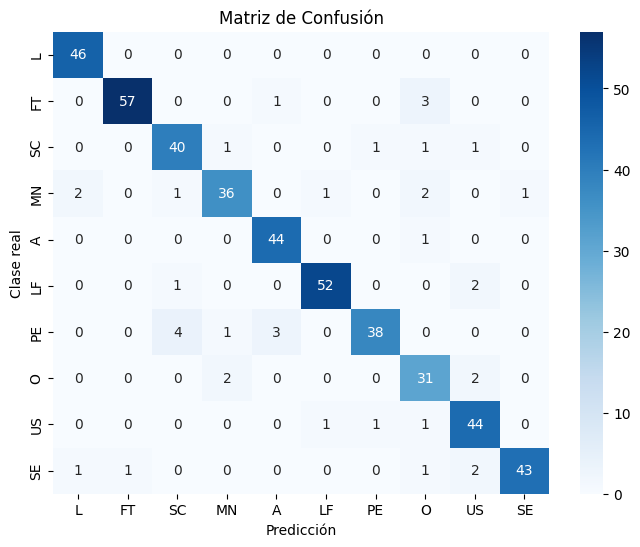

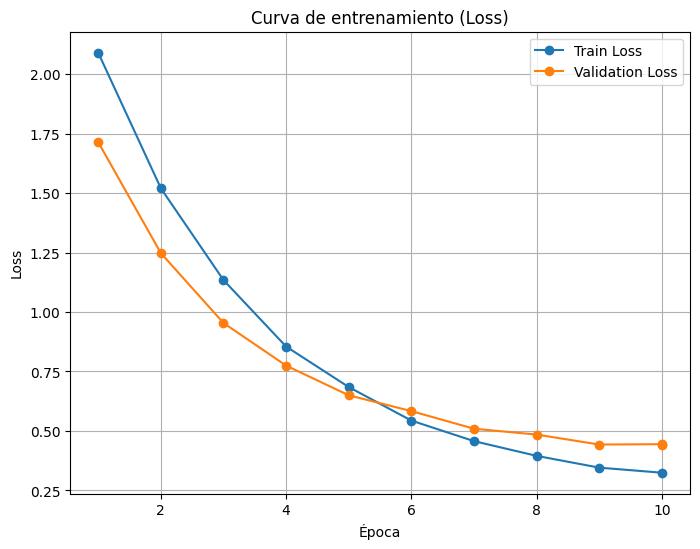

In [ ]:
# ====================================================
# 1. Cargar dataset y filtrar clases
# ====================================================
df = pd.read_csv('PROMISE_extended6.csv')
classes_to_keep = ['O', 'PE', 'SE', 'US', 'LF', 'A', 'FT', 'SC', 'L', 'MN']
df = df[df['class'].isin(classes_to_keep)].copy()

print("Class distribution:")
print(df['class'].value_counts())

# Mapear clases a IDs
label2id = {label: idx for idx, label in enumerate(df['class'].unique())}
id2label = {idx: label for label, idx in label2id.items()}
df['label'] = df['class'].map(label2id)

# Split en train y validación
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# ====================================================
# 2. Tokenizer y modelo
# ====================================================
model_name = "microsoft/mpnet-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["RequirementText"], padding="max_length", truncation=True, max_length=64)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

# Freeze layers ------------------------------
layers = model.base_model.encoder.layer
total_layers = len(layers) # 12
freeze_layers = 6

# Congelar las primeras 'freeze_layers'
for layer in layers[:freeze_layers]:
    for param in layer.parameters():
        param.requires_grad = False
# --------------------------------------------

# ====================================================
# 3. Métricas (accuracy, f1, precision, recall)
# ====================================================
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average='weighted'),
        "precision": precision_score(labels, predictions, average='weighted'),
        "recall": recall_score(labels, predictions, average='weighted')
    }

# ====================================================
# 4. Configuración de entrenamiento
# ====================================================
training_args = TrainingArguments(
    output_dir="./results10class",
    eval_strategy="epoch",     # evaluar cada época
    save_strategy="epoch",
    logging_strategy="epoch",        # loguear métricas cada época
    learning_rate=5e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="./logs",
    report_to="none"                 # evita logs extra en W&B
)

# ====================================================
# 5. Entrenador con early stopping
# ====================================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Entrenar
trainer.train()

# Evaluar
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

# ====================================================
# 6. Predicciones y matriz de confusión
# ====================================================
preds = trainer.predict(tokenized_val)
pred_labels = np.argmax(preds.predictions, axis=1)

# ====================================================
# 7. Classification Report y promedios globales
# ====================================================

print("\nClassification Report:")
print(classification_report(
    val_df['label'],
    pred_labels,
    target_names=[id2label[i] for i in range(len(id2label))]
))

# Calcular métricas globales (micro, macro, weighted)
avg_accuracy = accuracy_score(val_df['label'], pred_labels)

avg_precision_macro = precision_score(val_df['label'], pred_labels, average='macro')
avg_recall_macro    = recall_score(val_df['label'], pred_labels, average='macro')
avg_f1_macro        = f1_score(val_df['label'], pred_labels, average='macro')

avg_precision_weighted = precision_score(val_df['label'], pred_labels, average='weighted')
avg_recall_weighted    = recall_score(val_df['label'], pred_labels, average='weighted')
avg_f1_weighted        = f1_score(val_df['label'], pred_labels, average='weighted')

avg_precision_micro = precision_score(val_df['label'], pred_labels, average='micro')
avg_recall_micro    = recall_score(val_df['label'], pred_labels, average='micro')
avg_f1_micro        = f1_score(val_df['label'], pred_labels, average='micro')

print("\n===== Promedios Globales =====")
print(f"Accuracy         : {avg_accuracy:.4f}")

print("\n--- Macro Avg ---")
print(f"Precision (macro): {avg_precision_macro:.4f}")
print(f"Recall (macro)   : {avg_recall_macro:.4f}")
print(f"F1-score (macro) : {avg_f1_macro:.4f}")

print("\n--- Weighted Avg ---")
print(f"Precision (weighted): {avg_precision_weighted:.4f}")
print(f"Recall (weighted)   : {avg_recall_weighted:.4f}")
print(f"F1-score (weighted) : {avg_f1_weighted:.4f}")

print("\n--- Micro Avg ---")
print(f"Precision (micro): {avg_precision_micro:.4f}")
print(f"Recall (micro)   : {avg_recall_micro:.4f}")
print(f"F1-score (micro) : {avg_f1_micro:.4f}")

# Usar función
plot_confusion_matrix(val_df['label'], pred_labels, id2label)
plot_training_curves(trainer)